# Ray

In [ ]:
!pip install ray
!pip install python-dotenv

In [ ]:
import os
import ray

In [ ]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [ ]:
if ray.is_initialized():
  ray.shutdown()
ray.init()

2024-01-08 08:57:24,397	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.9.0


In [ ]:
ray.cluster_resources()

{'node:__internal_head__': 1.0,
 'memory': 7949456180.0,
 'GPU': 1.0,
 'node:172.28.0.12': 1.0,
 'CPU': 2.0,
 'accelerator_type:T4': 1.0,
 'object_store_memory': 3974728089.0}

In [ ]:
num_workers=1
resources_per_worker={"CPU":2,"GPU":1}


# Data

1: Data Ingestion

In [ ]:
import pandas as pd


In [ ]:
DATASET_LOC=pd.read_csv("/content/dataset.csv")

In [ ]:
DATASET_LOC.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


# EDA

In [ ]:
!pip install matplotlib
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

import wordcloud

In [ ]:
all_tags=Counter(DATASET_LOC.tag)

In [ ]:
all_tags

Counter({'computer-vision': 285,
         'other': 106,
         'natural-language-processing': 310,
         'mlops': 63})

In [ ]:
# zip(*all_tags.most_common())

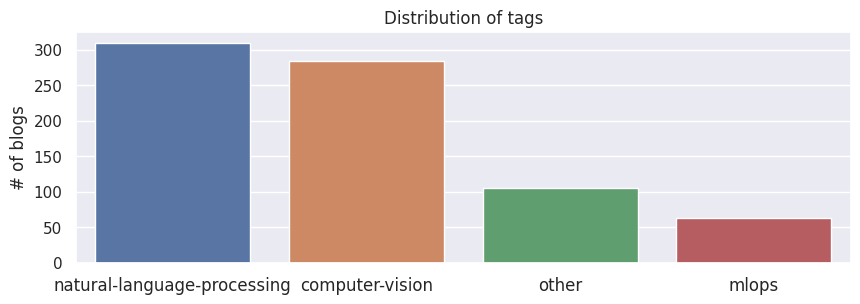

In [ ]:
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10,3))
ax=sns.barplot(x=list(tags),y=list(tag_counts))
ax.set_xticklabels(tags,rotation=0,fontsize=12)
plt.title("Distribution of tags")
plt.ylabel("# of blogs")
plt.show()

Imbalance Data

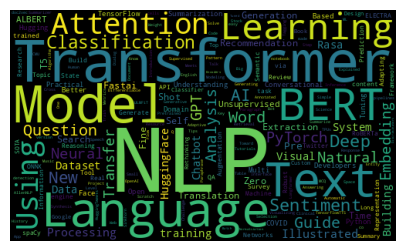

In [ ]:
tag="natural-language-processing"
plt.figure(figsize=(10,3))
subset=DATASET_LOC[DATASET_LOC.tag==tag]
# subset
text=subset.title.values
cloud=wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, background_color="black",collocations=False, width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

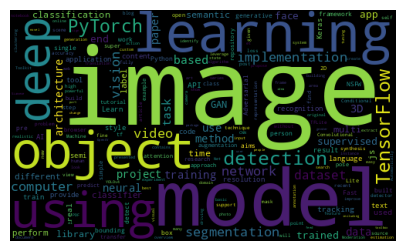

In [ ]:
tag="computer-vision"
plt.figure(figsize=(10,3))
subset=DATASET_LOC[DATASET_LOC.tag==tag]
# subset
text=subset.description.values ## title -> description
cloud=wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, background_color="black",collocations=False, width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Data PreProcessing  

  Global steps:
    
    1. Lowercase
    2. remove stopwords
    3. train test split
    4. standardiziation

In [ ]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [ ]:
DATASET_LOC["text"]=DATASET_LOC['title']+" " +DATASET_LOC["description"]

Data Cleaning

In [ ]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [ ]:
# Apply to dataframe
original_df = DATASET_LOC.copy()
DATASET_LOC.text = DATASET_LOC.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{DATASET_LOC.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [ ]:
# DataFrame cleanup
DATASET_LOC = DATASET_LOC.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
DATASET_LOC = DATASET_LOC.dropna(subset=["tag"])  # drop nulls
DATASET_LOC = DATASET_LOC[["text", "tag"]]  # rearrange cols
DATASET_LOC.head()

In [ ]:
# {cat, dog, elephant = 1,2,3}

tokenization

In [ ]:
# Label to index
tags = DATASET_LOC.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'computer-vision': 0,
 'other': 1,
 'natural-language-processing': 2,
 'mlops': 3}

In [ ]:
DATASET_LOC["tag"] = DATASET_LOC["tag"].map(class_to_index)
DATASET_LOC.head()

In [ ]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

index_to_class = {v:k for k, v in class_to_index.items()}
decode(DATASET_LOC.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

In [ ]:
import numpy as np
from transformers import BertTokenizer
# llm

In [ ]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [ ]:

def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [ ]:
DATASET_LOC.head(1)

,text,tag
0,comparison yolo rcnn real world videos bringin...,0


In [ ]:
# Tokenization
tokenize(DATASET_LOC.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([0])}

In [ ]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [ ]:
# Apply

DATASET_LOC=original_df.copy()
data=preprocess(df=DATASET_LOC, class_to_index=class_to_index)

In [ ]:
data

In [ ]:
!unzip /content/mlops.zip

In [ ]:
# !pip install mlflow
from mlops.data import stratify_split

In [ ]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [ ]:
ds = ray.data.read_csv("/content/dataset.csv")
ds = ds.random_shuffle(seed=1234)
ds.take(1)

In [ ]:
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)
train_ds

In [ ]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2024-01-08 10:57:18,388	WARNING util.py:546 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-01-08 10:57:18,400	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=4 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (2).
2024-01-08 10:57:18,402	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-01-08 10:57:18,405	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(fn)] -> LimitOperator[limit=1]
2024-01-08 10:57:18,407	INFO streaming_executor.py:113 -- Execution con

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-01-08 10:57:20,136	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=4 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (2).
2024-01-08 10:57:20,138	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-01-08 10:57:20,141	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(fn)] -> AllToAllOperator[Aggregate]
2024-01-08 10:57:20,146	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enab

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

In [ ]:
# sample_ds

In [ ]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

In [ ]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
def load_data(num_samples=None):
    ds = ray.data.read_csv("/content/dataset.csv")
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [ ]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self

    def transform(self, ds):
        return ds.map_batches(
            preprocess,
            fn_kwargs={"class_to_index": self.class_to_index},
            batch_format="pandas")

In [ ]:
import torch.nn as nn
from transformers import BertModel

In [ ]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [ ]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [ ]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs

    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [ ]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [ ]:
from ray.train.torch import get_device

In [ ]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [ ]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

In [ ]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

In [ ]:
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
import tempfile
import torch.nn.functional as F
from torch.nn.parallel.distributed import DistributedDataParallel

In [ ]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [ ]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [ ]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

In [ ]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

In [ ]:
# Class weights
batch_counts = []
for batch in train_ds.iter_torch_batches(batch_size=256, collate_fn=collate_fn):
    batch_counts.append(np.bincount(batch["targets"].cpu().numpy()))
counts = [sum(count) for count in zip(*batch_counts)]
class_weights = np.array([1.0/count for i, count in enumerate(counts)])
class_weights_tensor = torch.Tensor(class_weights).to(get_device())

# Training components
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)


In [ ]:
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [ ]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

In [ ]:
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path="/content/config")

In [ ]:
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-01-08 11:33:05,377	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=4 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (2).
2024-01-08 11:33:05,379	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-01-08 11:33:05,381	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-01-08 11:33:05,383	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-01-08 11:33:05,384	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContex

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor =  preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-01-08 11:33:05,904	WARNING util.py:546 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-01-08 11:33:05,917	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=4 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (2).
2024-01-08 11:33:05,918	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-01-08 11:33:05,923	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(fn)] -> LimitOperator[limit=1]
2024-01-08 11:33:05,924	INFO streaming_executor.py:113 -- Execution con

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-01-08 11:33:06,941	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=4 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (2).
2024-01-08 11:33:06,943	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-01-08 11:33:06,945	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(fn)] -> AllToAllOperator[Aggregate]
2024-01-08 11:33:06,946	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enab

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-01-08 11:33:08,708	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=4 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (2).
2024-01-08 11:33:08,710	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-01-08 11:33:08,712	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-01-08 11:33:08,713	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progr

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-01-08 11:33:11,067	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=4 for stage ReadCSV to satisfy parallelism at least twice the available number of CPUs (2).
2024-01-08 11:33:11,069	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-01-08 11:33:11,072	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-01-08 11:33:11,075	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progr

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/1 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

In [ ]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [ ]:
%%time
# Train
results = trainer.fit()

In [ ]:
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,...,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.0001,0.584513,0.495964,1704713612,checkpoint_000000,True,False,1,b52dc_00000,...,172.28.0.12,15.366657,1,0.5,0.0001,0.8,3,10,256,4
1,1,0.0001,0.497197,0.446006,1704713619,checkpoint_000001,True,False,2,b52dc_00000,...,172.28.0.12,22.744294,2,0.5,0.0001,0.8,3,10,256,4
2,2,0.0001,0.403824,0.332609,1704713626,checkpoint_000002,True,False,3,b52dc_00000,...,172.28.0.12,29.852726,3,0.5,0.0001,0.8,3,10,256,4
3,3,0.0001,0.293863,0.276246,1704713638,checkpoint_000003,True,False,4,b52dc_00000,...,172.28.0.12,45.461779,4,0.5,0.0001,0.8,3,10,256,4
4,4,0.0001,0.222581,0.198546,1704713649,checkpoint_000004,True,False,5,b52dc_00000,...,172.28.0.12,52.533939,5,0.5,0.0001,0.8,3,10,256,4
5,5,0.0001,0.148702,0.183702,1704713656,checkpoint_000005,True,False,6,b52dc_00000,...,172.28.0.12,59.575604,6,0.5,0.0001,0.8,3,10,256,4
6,6,0.0001,0.104155,0.171154,1704713669,checkpoint_000006,True,False,7,b52dc_00000,...,172.28.0.12,71.463004,7,0.5,0.0001,0.8,3,10,256,4
7,7,0.0001,0.077252,0.154235,1704713676,checkpoint_000007,True,False,8,b52dc_00000,...,172.28.0.12,78.518977,8,0.5,0.0001,0.8,3,10,256,4
8,8,0.0001,0.055919,0.146915,1704713683,checkpoint_000008,True,False,9,b52dc_00000,...,172.28.0.12,89.874735,9,0.5,0.0001,0.8,3,10,256,4
9,9,0.0001,0.043831,0.146980,1704713695,checkpoint_000009,True,False,10,b52dc_00000,...,172.28.0.12,96.893252,10,0.5,0.0001,0.8,3,10,256,4


In [ ]:
# Best checkpoints
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/content/config/llm/TorchTrainer_b52dc_00000_0_2024-01-08_11-33-13/checkpoint_000008),
  {'epoch': 8,
   'lr': 0.0001,
   'train_loss': 0.0559187705318133,
   'val_loss': 0.14691513776779175,
   'timestamp': 1704713683,
   'checkpoint_dir_name': 'checkpoint_000008',
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 9,
   'trial_id': 'b52dc_00000',
   'date': '2024-01-08_11-34-49',
   'time_this_iter_s': 11.35575795173645,
   'time_total_s': 89.87473487854004,
   'pid': 40447,
   'hostname': '3c52a0e8b338',
   'node_ip': '172.28.0.12',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 256,
     'num_classes': 4}},
   'time_since_restore': 89.87473487854004,
   'iterations_since_restore': 9})]